In [18]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [6]:
df = pd.read_csv('creditcard.csv')
df.shape
print("Total time spanning: {:.1f} days".format(df['Time'].max() / (3600 * 24.0)))
print("{:.3f} % of all transactions are fraud. ".format(np.sum(df['Class']) / df.shape[0] * 100))
df.head()
df.columns
df.dtypes


Total time spanning: 2.0 days
0.173 % of all transactions are fraud. 


Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

/Users/amber.ved/anaconda/envs/tf-cpu/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/amber.ved/anaconda/envs/tf-cpu/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/amber.ved/anaconda/envs/tf-cpu/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/amber.ved/anaconda/envs/tf-cpu/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is dep

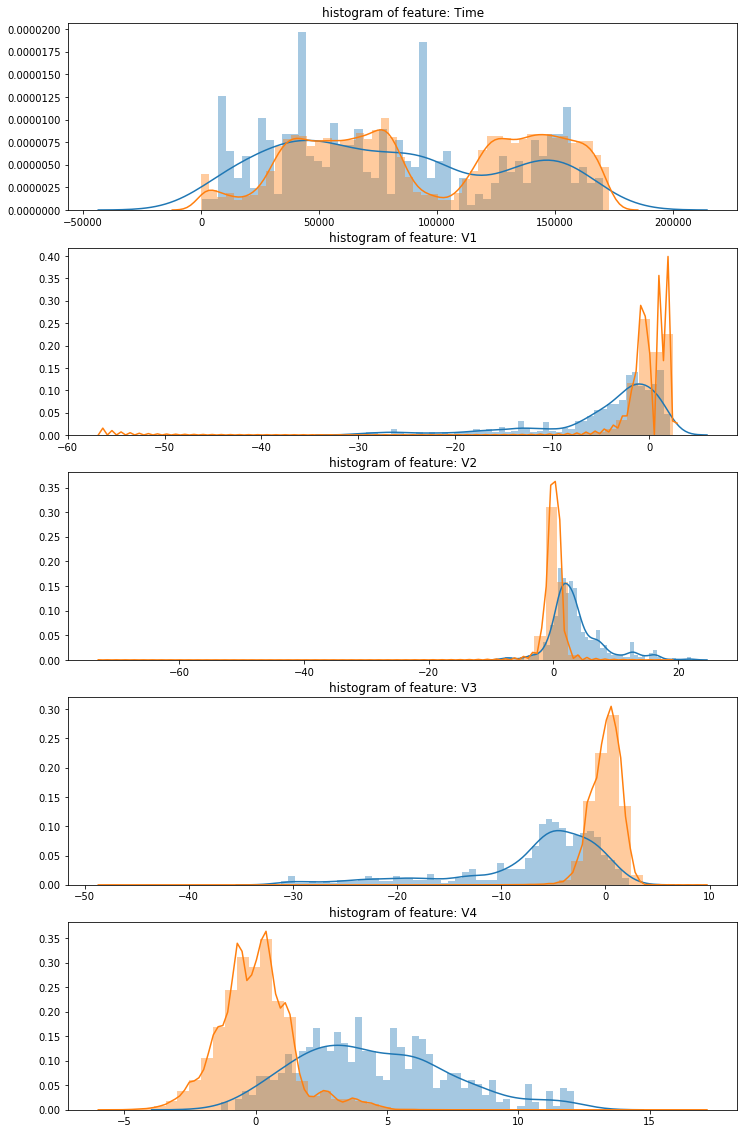

In [4]:
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5, 1)
for i, cn in enumerate(df.columns[:5]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [11]:
TEST_RATIO = 0.25
df.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_y = df.iloc[:TRA_INDEX, -1].values

test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_y = df.iloc[TRA_INDEX:, -1].values

In [12]:
print("Total train examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(train_x.shape[0], np.sum(train_y), np.sum(train_y)/train_x.shape[0]))
print("Total test examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(test_x.shape[0], np.sum(test_y), np.sum(test_y)/test_y.shape[0]))

Total train examples: 213605, total fraud cases: 398, equal to 0.00186 of total cases. 
Total test examples: 71202, total fraud cases: 94, equal to 0.00132 of total cases. 


In [14]:
'''cols_max = []
cols_min = []
for c in range(train_x.shape[1]):
    cols_max.append(train_x[:,c].max())
    cols_min.append(train_x[:,c].min())
    train_x[:, c] = (train_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])
    test_x[:, c] =  (test_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])'''

'cols_max = []\ncols_min = []\nfor c in range(train_x.shape[1]):\n    cols_max.append(train_x[:,c].max())\n    cols_min.append(train_x[:,c].min())\n    train_x[:, c] = (train_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])\n    test_x[:, c] =  (test_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])'

In [15]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

In [16]:
# Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 256
display_step = 1

# Network Parameters
n_hidden_1 = 15 # 1st layer num features
#n_hidden_2 = 15 # 2nd layer num features
n_input = train_x.shape[1] # MNIST data input (img shape: 28*28)
data_dir = '.'

In [19]:
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    #'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    #'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   #biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                  # biases['decoder_b2']))
    return layer_1

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# TRAIN StARTS
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_x.shape[0], batch_size)
            batch_xs = train_x[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            train_batch_mse = sess.run(batch_mse, feed_dict={X: train_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Train auc=", "{:.6f}".format(auc(train_y, train_batch_mse)), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)

Epoch: 0001 cost= 1.307971597 Train auc= 0.953205 Time elapsed= 0:00:01.032010
Epoch: 0002 cost= 0.700766861 Train auc= 0.954684 Time elapsed= 0:00:01.988340
Epoch: 0003 cost= 0.728679121 Train auc= 0.955931 Time elapsed= 0:00:02.920764
Epoch: 0004 cost= 0.587579608 Train auc= 0.957877 Time elapsed= 0:00:03.842213
Epoch: 0005 cost= 0.571035564 Train auc= 0.956579 Time elapsed= 0:00:04.782450
Epoch: 0006 cost= 0.509554029 Train auc= 0.955808 Time elapsed= 0:00:05.703540
Epoch: 0007 cost= 0.757638276 Train auc= 0.955505 Time elapsed= 0:00:06.626110
Epoch: 0008 cost= 0.415440291 Train auc= 0.956136 Time elapsed= 0:00:07.573955
Epoch: 0009 cost= 0.394643486 Train auc= 0.956757 Time elapsed= 0:00:08.490186
Epoch: 0010 cost= 0.540096283 Train auc= 0.957051 Time elapsed= 0:00:09.462723
Optimization Finished!
Model saved in file: ./temp_saved_model_1layer.ckpt


In [20]:
save_model = os.path.join(data_dir, 'models/temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse = sess.run(batch_mse, feed_dict={X: test_x})
    
    print("Test auc score: {:.6f}".format(auc(test_y, test_batch_mse)))
    

INFO:tensorflow:Restoring parameters from ./temp_saved_model_1layer.ckpt
Test auc score: 0.940300
